In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize

%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


Load a fixation dataset (1 subject) and set up experiment specific parameters.

In [2]:
import pandas as pd
Fixtmp = pd.read_csv('fixation_tbl.csv')

# parameters
xSize, ySize = 706, 706
# pixel per-visual degree
# Screen Resolution
Res         = np.array([0., 0., 1920., 1080.])
# Screen  Screen_Size in cm
Screen_Size = np.array([52.128, 29.322])
# View distance of subjects in cm
Distance    = 70.
# Degree per visual angle
from math import atan2, degrees
DPP = degrees(atan2(.5*Screen_Size[0], Distance)) / (.5*Res[2])
pixel_deg = 1/DPP

In [3]:
Fixtmp.head(5)

,Unnamed: 0,xfix,yfix,fixdur,fixnum,t0,t1,s0,s1,item,phase,xfix_raw,yfix_raw
0,70115,597.951361,240.446823,187.134093,1,0.000022,0.187157,1,211,6352,Target,597.951361,240.446823
1,70116,372.993165,342.431292,102.641000,2,0.224731,0.327372,253,370,6352,Target,372.993165,342.431292
2,70117,343.771177,470.436654,147.038900,3,0.357297,0.504336,404,570,6352,Target,343.771177,470.436654
3,70118,338.514308,497.676332,205.823200,4,0.525286,0.731109,594,826,6352,Target,338.514308,497.676332
4,70119,341.317094,351.670171,209.525100,5,0.758206,0.967731,857,1093,6352,Target,341.317094,351.670171


Get the three variable for fixation mapping: fixation location (x and y) and fixation duration (ms).

In [14]:
xfix    = np.asarray(Fixtmp.xfix)
yfix    = np.asarray(Fixtmp.yfix)
fixdur  = np.asarray(Fixtmp.fixdur)
idx0    = (np.isfinite(xfix)) & (np.isfinite(yfix)) & (np.isfinite(fixdur))
idx1    = np.asarray((Fixtmp['phase'] == 'Target') & idx0)
idx2    = np.asarray((Fixtmp['phase'] == 'Prob') & idx0)

X = np.asarray([xfix[idx1], ySize-yfix[idx1]]).transpose()
Y = np.asarray([fixdur[idx1]]).transpose()

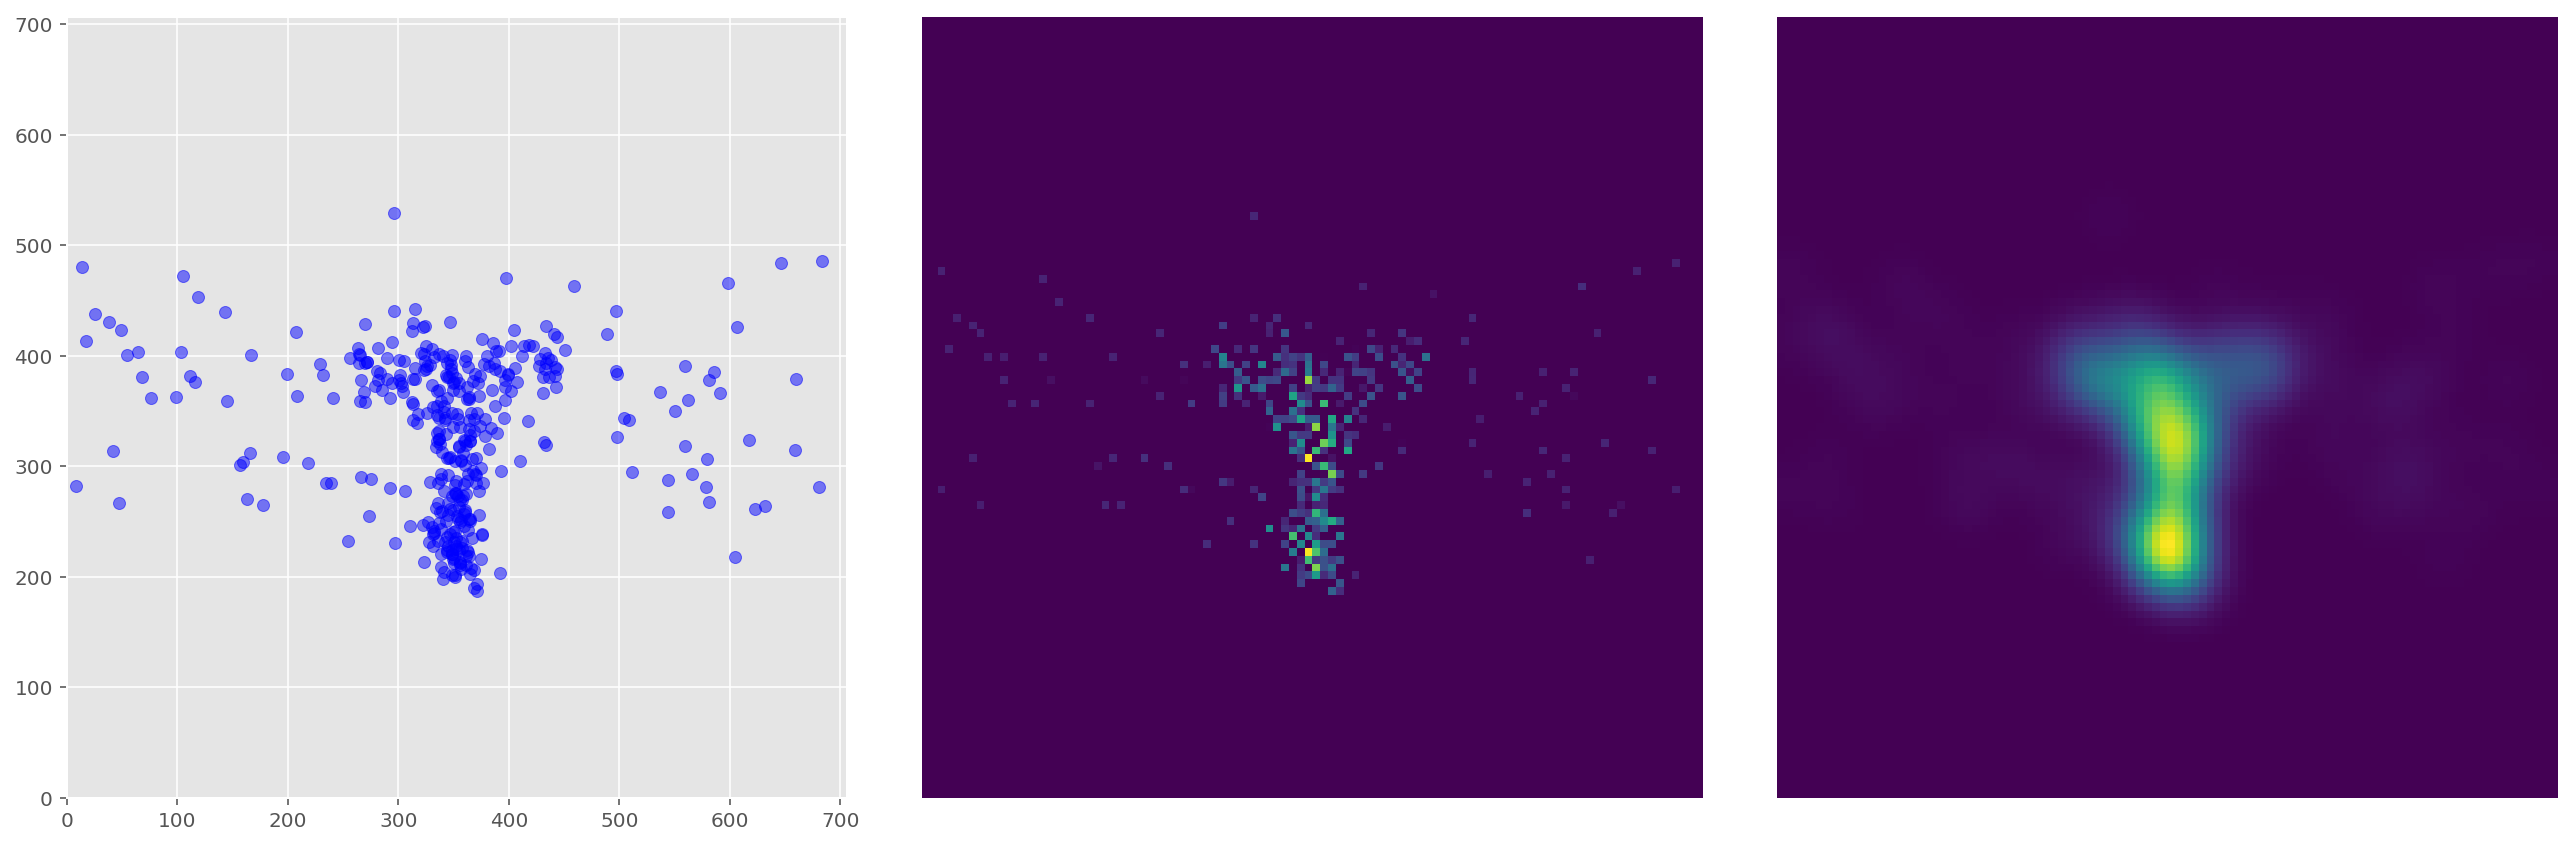

In [5]:
from scipy.sparse import coo_matrix
from scipy.ndimage.filters import gaussian_filter
f, axes1 = plt.subplots(1, 3, figsize=(18, 6))

axes1[0].scatter(xfix[idx1],ySize-yfix[idx1],\
            alpha=.5, color='b')
axes1[0].set(xlim=(0, xSize), ylim=(0, ySize), )
axes1[0].set_aspect('equal')

col = np.asarray(xfix[idx1],dtype=int)
row = np.asarray(yfix[idx1],dtype=int)
dur = np.asarray(fixdur[idx1])
indexnew = (col>=0)&(col<xSize)&(row>=0)&(row<ySize)
rawmap = coo_matrix((dur[indexnew], (row[indexnew], col[indexnew])), shape=(xSize, ySize)).toarray()

xSize_rz, ySize_rz = 100,100
col_rz = np.digitize(xfix[idx1], np.linspace(0,xSize,xSize_rz))
row_rz = np.digitize(yfix[idx1], np.linspace(0,ySize,ySize_rz))
indexnew = (col_rz>=0)&(col_rz<xSize_rz)&(row_rz>=0)&(row_rz<ySize_rz)
rawmaprz = coo_matrix((dur[indexnew], (row_rz[indexnew], col_rz[indexnew])), shape=(xSize_rz, ySize_rz)).toarray()
axes1[1].imshow(rawmaprz,cmap='viridis',interpolation='none')
axes1[1].axis('off')

#from skimage.transform import resize
#smoothpic = gaussian_filter(rawmap, sigma_smooth)
#smoothpic = resize(smoothpic,(xSize_rz, ySize_rz))
fwhm = 1 * pixel_deg
sigma_smooth = fwhm/(2.*np.sqrt(2.*np.log(2.)))
smoothpic = gaussian_filter(rawmaprz, sigma_smooth/(xSize/xSize_rz))
axes1[2].imshow(smoothpic,cmap='viridis',interpolation='none')
axes1[2].axis('off')

f.tight_layout()

The motivation of smoothing here is to account for the measurement noise (.5 degree radius from eye tracker). However, this parameter is arbitrary and fixed by hand.

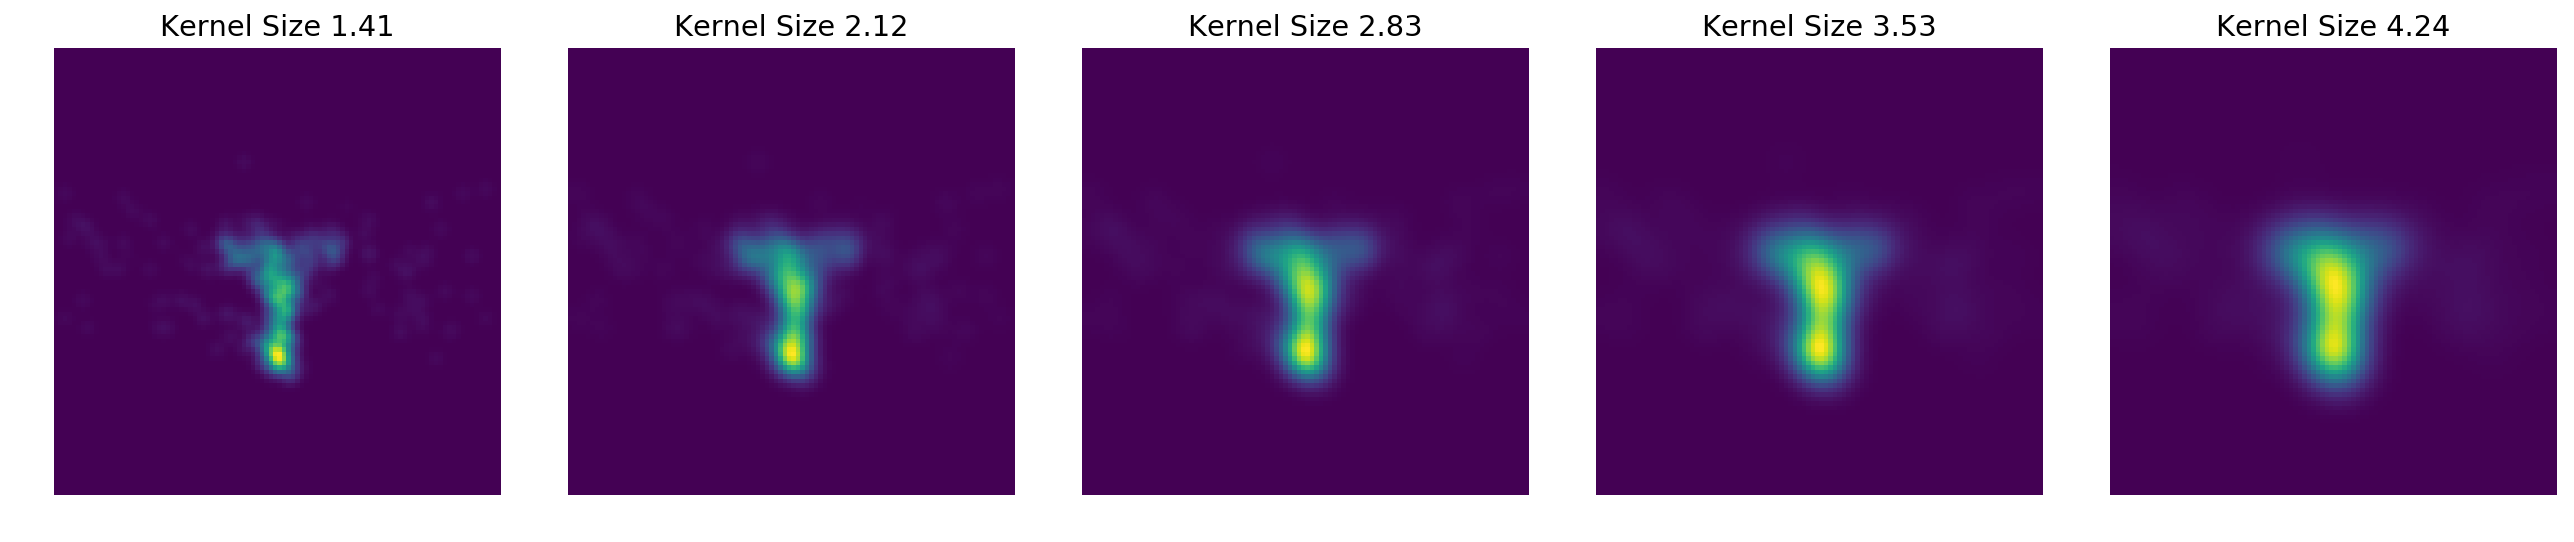

In [6]:
sm_base = fwhm/(2.*np.sqrt(2.*np.log(2.)))/(xSize/xSize_rz)
sm_base *= np.asarray([.5, .75 ,1., 1.25, 1.5])
plt.figure(figsize=(18, 4))
for i, sm in enumerate(sm_base):
    plt.subplot(1,5,i+1)
    
    smoothpic = gaussian_filter(rawmaprz, sm)
    plt.imshow(smoothpic,cmap='viridis',interpolation='none')
    plt.title('Kernel Size %.2f' % sm)
    plt.axis('off')

plt.tight_layout()

Using Gaussian Process for the smoothing

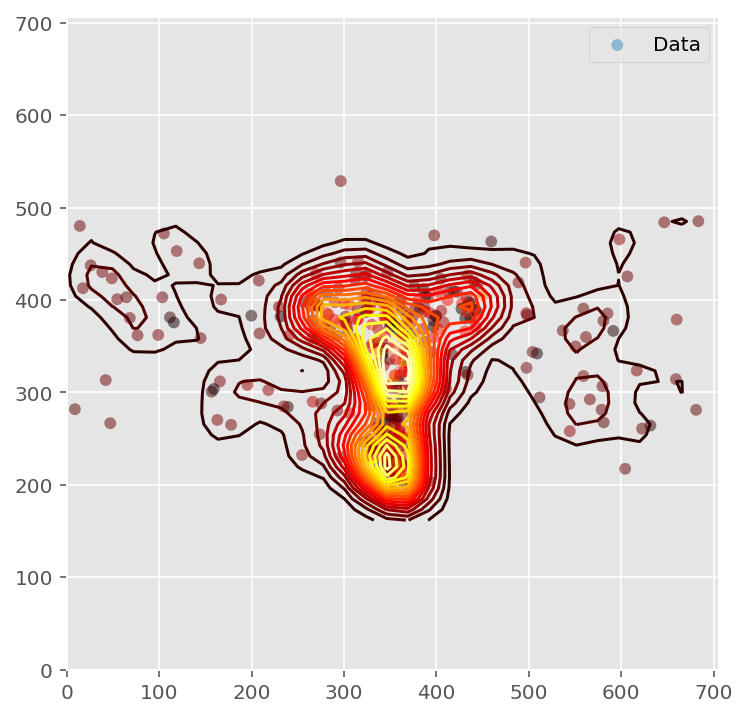

In [7]:
import GPy
ker = GPy.kern.RBF(2,ARD=True)# + GPy.kern.White(2)
# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)
m.kern.lengthscale.fix([sigma_smooth,sigma_smooth])
m.kern.variance.fix(0.1)
#m.optimize()
# optimize and plot
_, axes = plt.subplots(1, 1, figsize=(18, 6))
m.plot(ax=axes)
axes.set(xlim=(0, xSize), ylim=(0, ySize))
axes.set_aspect('equal')
plt.show()

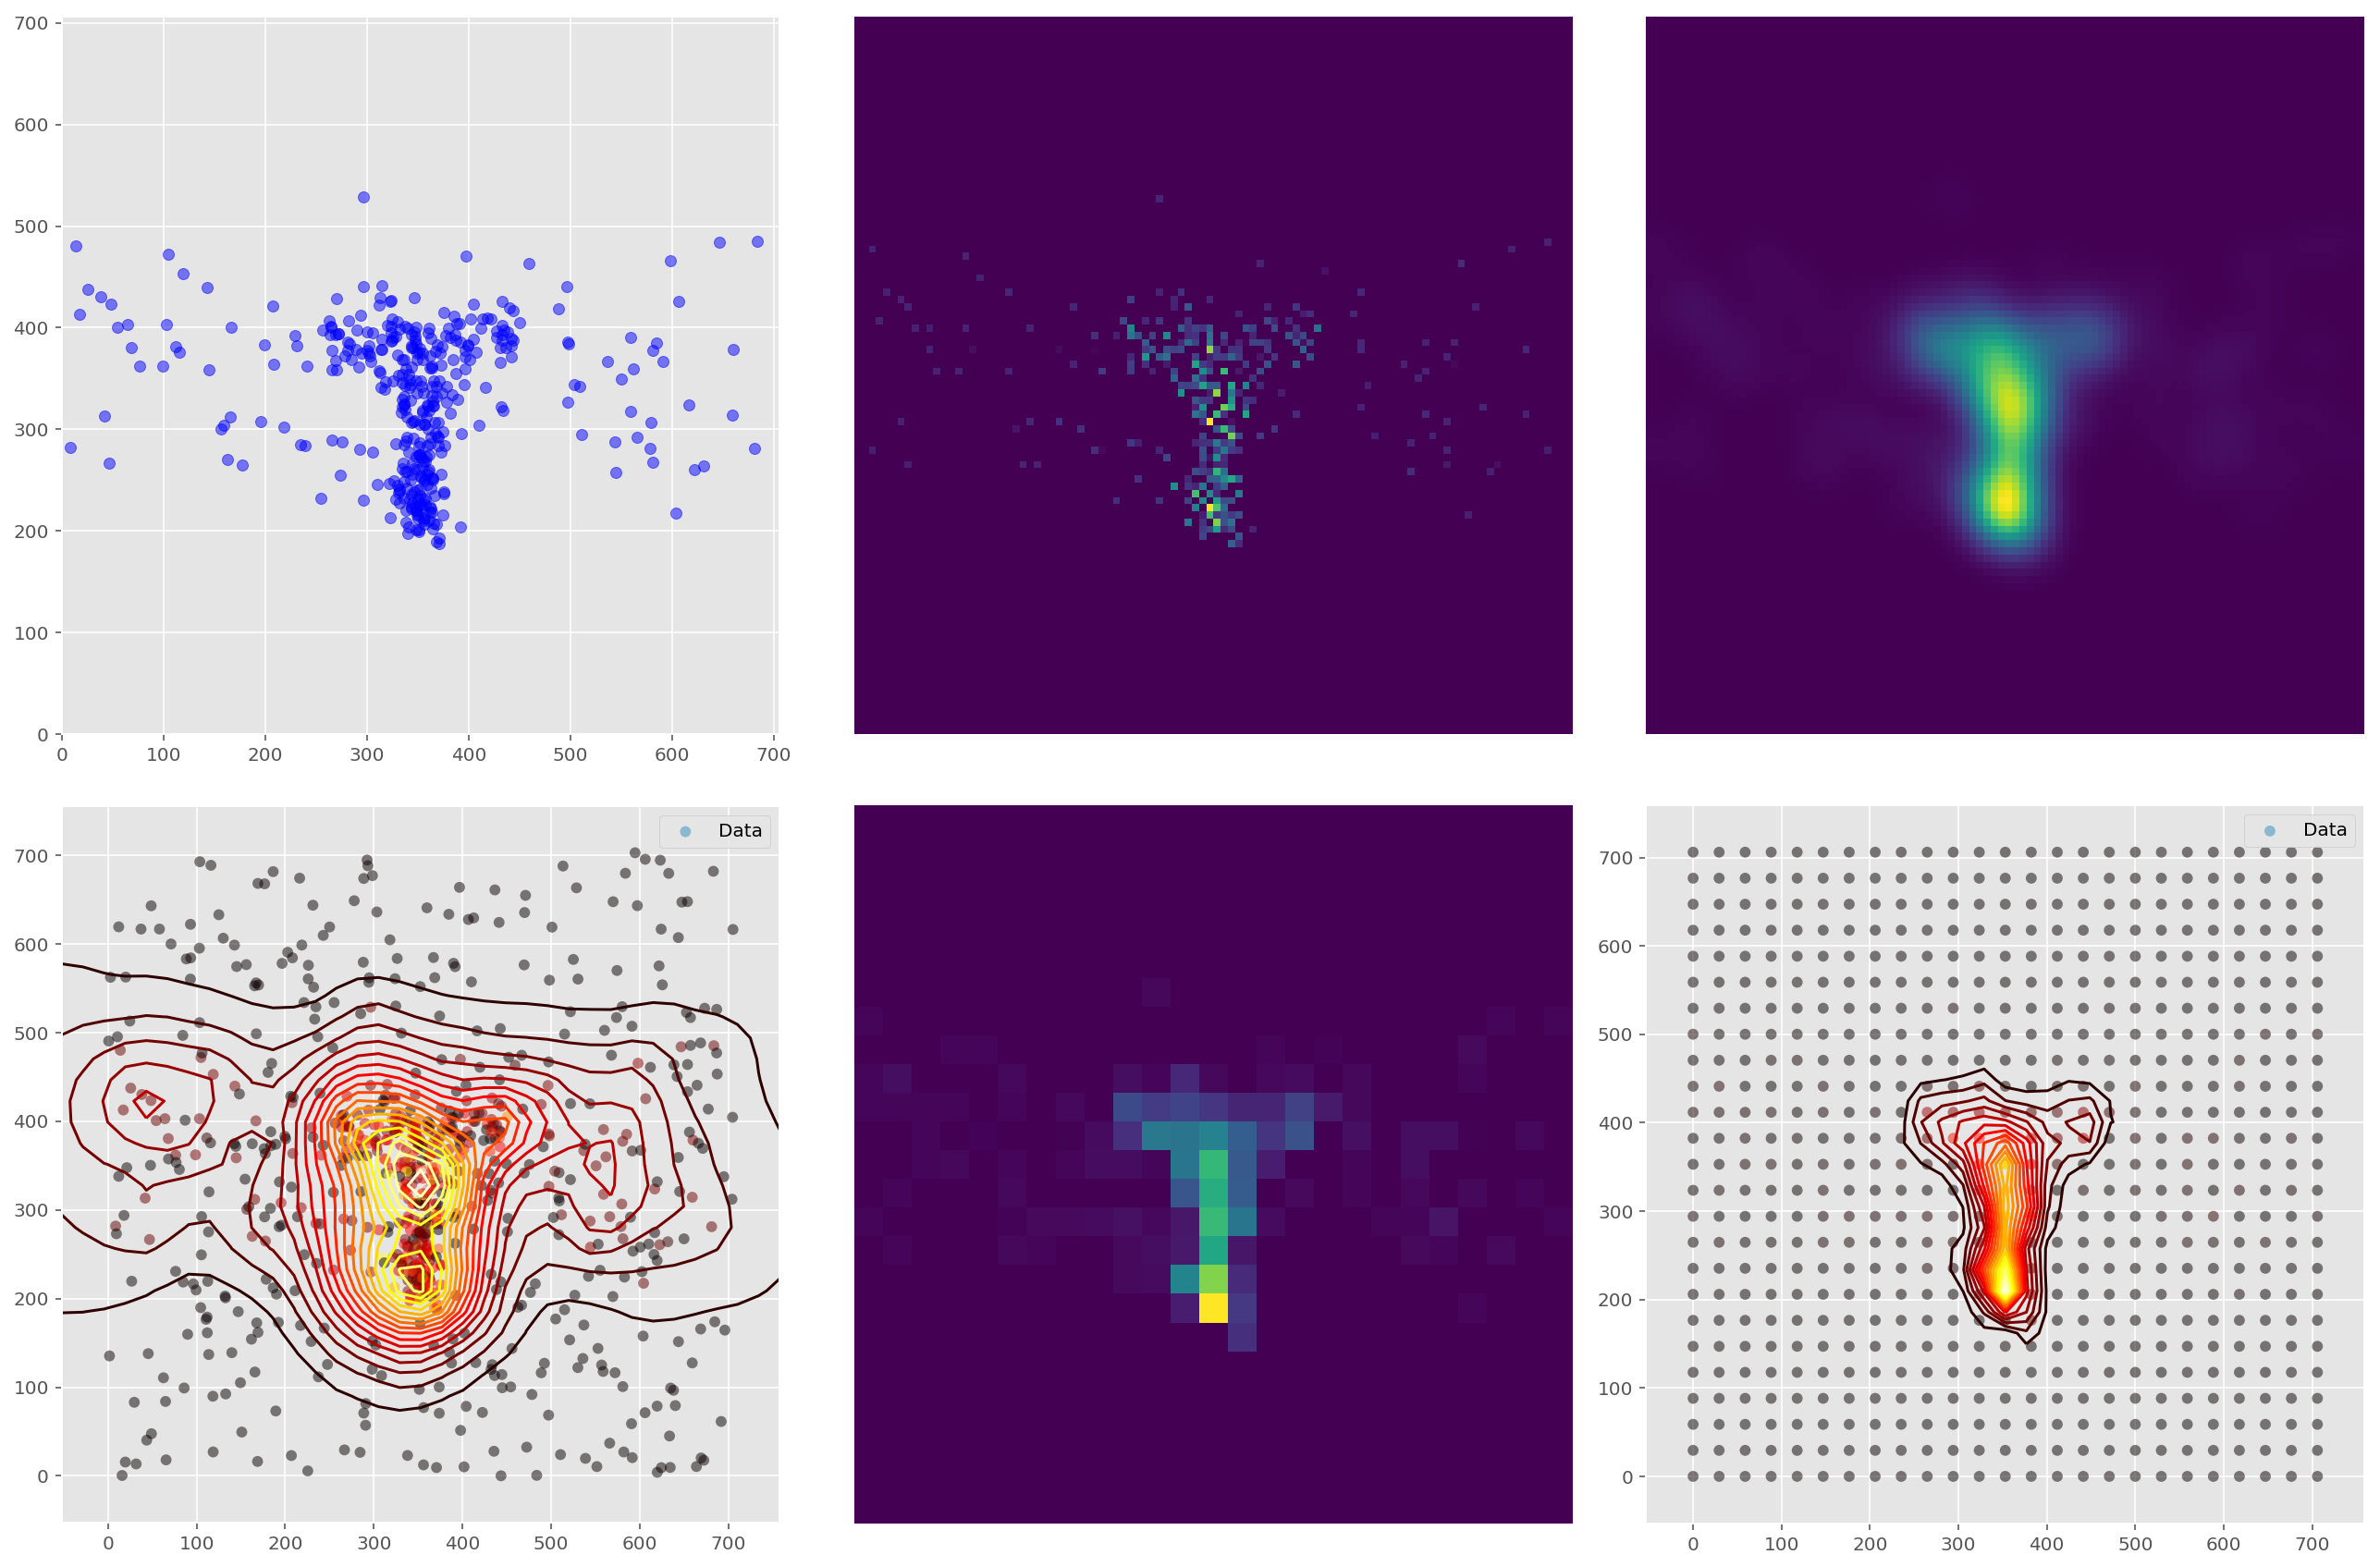

In [21]:
f, axes1 = plt.subplots(2, 3, figsize=(18, 12))

axes1[0,0].scatter(xfix[idx1],ySize-yfix[idx1],\
            alpha=.5, color='b')
axes1[0,0].set(xlim=(0, xSize), ylim=(0, ySize), )
axes1[0,0].set_aspect('equal')

col = np.asarray(xfix[idx1],dtype=int)
row = np.asarray(yfix[idx1],dtype=int)
dur = np.asarray(fixdur[idx1])
indexnew = (col>=0)&(col<xSize)&(row>=0)&(row<ySize)
rawmap = coo_matrix((dur[indexnew], (row[indexnew], col[indexnew])), shape=(xSize, ySize)).toarray()

xSize_rz, ySize_rz = 100,100
col_rz = np.digitize(xfix[idx1], np.linspace(0,xSize,xSize_rz))
row_rz = np.digitize(yfix[idx1], np.linspace(0,ySize,ySize_rz))
indexnew = (col_rz>=0)&(col_rz<xSize_rz)&(row_rz>=0)&(row_rz<ySize_rz)
rawmaprz = coo_matrix((dur[indexnew], (row_rz[indexnew], col_rz[indexnew])), shape=(xSize_rz, ySize_rz)).toarray()
axes1[0,1].imshow(rawmaprz,cmap='viridis',interpolation='none')
axes1[0,1].axis('off')

smoothpic = gaussian_filter(rawmaprz, sigma_smooth/(xSize/xSize_rz))
axes1[0,2].imshow(smoothpic,cmap='viridis',interpolation='none')
axes1[0,2].axis('off')

# random sample from empty space for zeros
x_train2=(np.random.rand(X.shape[0],X.shape[1]))*xSize
Xtrain = np.vstack((X,x_train2))
Ytrain = np.vstack((Y,np.zeros((len(X),1))))

# define kernel
ker = GPy.kern.Exponential(2, ARD=True)# + GPy.kern.White(2)
# create simple GP model
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)
# optimize and plot
m.optimize()

sizexy=25
scale =sizexy/xSize
xfix_ = (X[:,0]+2)*scale
yfix_ = (X[:,1]+2)*scale
col = np.asarray(xfix_,dtype=int)
col[col>=sizexy]=sizexy-1
row = np.asarray(yfix_,dtype=int)
row[row>=sizexy]=sizexy-1

dur = np.asarray(Y.flatten())
rawmap = coo_matrix((dur, (row, col)), shape=(sizexy, sizexy)).toarray()
m.plot(ax=axes1[1,0])
axes1[1,0].set_aspect('equal')

axes1[1,1].imshow(rawmap,cmap='viridis',interpolation='none',origin='lower')
axes1[1,1].axis('off')

x1 = np.linspace(0, xSize, sizexy)
y1 = np.linspace(0, xSize, sizexy)
xx, yy = np.meshgrid(x1, y1)

Xtrain2 = np.hstack((np.reshape(xx,(sizexy**2,1)),np.reshape(yy,(sizexy**2,1))))
Ytrain2 = np.reshape(rawmap,(sizexy**2,1))

kg2 = GPy.kern.Exponential(2, ARD=True)
mm2 = GPy.models.GPRegression(Xtrain2, Ytrain2, kernel=kg2)
mm2.optimize()
mm2.plot(ax=axes1[1,2])
axes1[1,2].set_aspect('equal')

f.tight_layout()